# Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os

from tqdm import tqdm

# a simple workround for the new error in h5py version 3
# !pip install h5py==2.10.0 --force-reinstall

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.models import load_model

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV

SMALL_SIZE = 20//1.4
MEDIUM_SIZE = 24//1.4
BIGGER_SIZE = 28//1.4

import matplotlib
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Arial') 

plt.rc('font', size=SMALL_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)    
plt.rc('axes', labelsize=MEDIUM_SIZE)   
plt.rc('xtick', labelsize=SMALL_SIZE)   
plt.rc('ytick', labelsize=SMALL_SIZE)   
plt.rc('legend', fontsize=SMALL_SIZE)   
plt.rc('figure', titlesize=BIGGER_SIZE) 

def set_seed(seedNum = 42):
    np.random.seed(seedNum)
    tf.random.set_seed(seedNum)

In [2]:
seedNum = 43
set_seed(seedNum)

def scaler(X_train, X_valid, X_test, scaler = False):
    '''standard scaling'''
    if scaler:
        X_train = scaler.transform(X_train)
    else:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    X_test = scaler.transform(X_test)
    return X_train, X_valid, X_test, scaler

def preprocessing(X,
                  Y,
                  NumInputs,
                  NumOutputs,
                  scalerList=False,
                  test_size=0.25,
                  random_state=seedNum,
                  NumberOfSamples=300,
                  modelType='RNN'):
    
    '''preprocessing the datasets'''
    
    if not scalerList: scalerList = [False] * (NumOutputs + 1)
    
    numFrame = int(X.shape[-1]/NumInputs)
    # import pdb; pdb.set_trace()
    X_train_full, X_test, y_train_full, y_test = train_test_split(X,
                                                                  Y,
                                                                  test_size=test_size,
                                                                  random_state=random_state)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_full,
                                                          y_train_full,
                                                          test_size=0.25,
                                                          random_state=random_state)
    
    X_train, X_valid, X_test, scalerList[0] = scaler(X_train,
                                                     X_valid,
                                                     X_test,
                                                     scalerList[0])
    
    for i in range(NumOutputs):
        y_train[:,:,i], y_valid[:,:,i], y_test[:,:,i], scalerList[i+1] = scaler(y_train[:,:,i],
                                                                                y_valid[:,:,i],
                                                                                y_test[:,:,i],
                                                                                scalerList[i+1])
    
    y_train = y_train.reshape(y_train.shape[0], -1)
    y_valid = y_valid.reshape(y_valid.shape[0], -1)
    y_test = y_test.reshape(y_test.shape[0], -1)
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test, scalerList[:]

In [3]:
X = np.loadtxt('input_2d.csv', delimiter=",", dtype='float32')
Y = np.loadtxt('output_2d.csv', delimiter=",", dtype='float32')

In [4]:
NumberOfSamples = int(X[-1][-1])

# removing identifier of samples in each dataset:
Y = Y[:,:-1]
X = X[:,:-1]

NumInputs = X.shape[-1]
NumOutputs = Y.shape[-1]

In [5]:
# fixing the dimentions:
Y = Y.reshape(NumberOfSamples, -1, NumOutputs)

In [6]:
set_seed()
X_train, X_valid, X_test, y_train, y_valid, y_test, _ = preprocessing(X = X,
                                                                      Y = Y,
                                                                      NumInputs = NumInputs,
                                                                      NumOutputs = NumOutputs,
                                                                      test_size = 0.5)

In [38]:
def abaqus(data,
           num_outputs = 4,
           header = ['S22'],
           title = 'visualization',
           script = 'Visualization.py',
           min_contour = 0,
           max_contour = 2,):
    
    data = np.array(data)
    path = 'temp_' + title.replace(' ', '_')
    data = data.reshape(-1,num_outputs)
    data = data[:,:len(header)]
    np.savetxt(path, X = data, delimiter=",")
    
    # adding the path variable in Visualization.py:
    txt = []
    with open(script, 'r') as f:
        txt = f.readlines()
        idx = txt.index('# START OF AUTOMATICALLY GENERATED PYTHON CODE 1\n')
        txt[idx + 1] = 'path = "%s"\n'%(path)
        
        idx = txt.index('# START OF AUTOMATICALLY GENERATED PYTHON CODE 2\n')
        txt[idx + 1] = ('viewportObj.odbDisplay.contourOptions.setValues(maxAutoCompute=OFF,'
                        ' maxValue=%s, minAutoCompute=OFF, minValue=%s)\n'%(max_contour, min_contour))
    
    with open(script, 'w') as f: f.writelines(txt)
    
    # run abaqus
    parentFolder = 'C:\\temp\\PointMSE\\'
    os.system('abaqus cae noGUI=' + parentFolder + 'Visualization.py');
    
    lst = [i for i in os.listdir() if path == i[:len(path)] and 'png'== i[-3:]]
    img = [mpimg.imread(i)[:, 200:-200, :] for i in lst]
    
    return img

In [86]:
def run(load_trained_model = True, # trained_model can take the previously fitted model
        epochs = 200,
        lr = 1e-4,
        activation= 'relu',
        patience = 100,
        num_layers = 4,
        denominator = 100,):
    
    if load_trained_model == True:
        model = load_model('trained_model.h5')
    
    else:
        set_seed()
        last_units=y_train.shape[-1]
        units = last_units//denominator
        
        model = keras.models.Sequential()
        
        model.add(BatchNormalization())
        model.add(Dense(units=units, activation=activation))
        model.add(BatchNormalization())
        model.add(Dense(last_units))
        
        model.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(lr))
    
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        validation_data=(X_valid, y_valid),
                        verbose=0)
    
    model.save('trained_model.h5')
    return model.predict(X_test), X_test

In [192]:
def plot_data(load_trained_model, epochs):
    
    predict, X_test = run(epochs = epochs, load_trained_model = load_trained_model)
    
    mse = np.mean(np.square(y_test - predict), axis=-1)
    
    
    
    pmse = np.mean(np.square(y_test - predict), axis=0).reshape(1,-1)
    
    img_pmse = abaqus(data = pmse, num_outputs = 1, min_contour = 0, max_contour = 2)
    img_pmse = np.array(img_pmse)[0,:,:,:]
    
    # print(np.argmax(mse)) # Used to check one of the index for one of the highest errors, use np.argmax(mse) instead of 78.
    data = np.abs(y_test - predict)[78]
    img_sample = abaqus(data = data.reshape(1,-1), num_outputs = 1, min_contour = 0, max_contour = 4)
    img_sample = np.array(img_sample)[0,:,:,:]
    
    
    #img_sample = abaqus(data = predict[idx_max].reshape(1,-1), num_outputs = 1)
    #img_sample = np.array(img_sample)[0,:,:,:]
    
    result = {"img_pmse": img_pmse, "img_sample": img_sample, "mse": mse, "X": X_test[78]}
    return result

In [193]:
data = dict()
epoch = 40
boxplot_data = []

for i in tqdm(range(6), position=0):
    
    if i == 0:
        load_trained_model = False 
    else:
        load_trained_model = True
    
    data[epoch*(i+1)] = plot_data(load_trained_model = load_trained_model, epochs = epoch)
    boxplot_data.append(data[epoch*(i+1)]["mse"])

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:45<00:00, 17.58s/it]


In [194]:
def plot_epoch(key = "img_pmse", fileName = 'visualization.pdf'):
    plt.clf();
    
    columns = 2
    rows = 3
    
    fig = plt.figure(figsize=(20, 15))
    
    ax = []
    boxplot_data = []
    for i in range(columns*rows):
        print 
        ax.append(fig.add_subplot(rows, columns, i+1))
        ax[-1].set_xticks([])
        ax[-1].set_yticks([])
        ax[-1].axis('off')
        
        img = data[epoch*(i+1)][key][600:-500, 300:-400, :]
        
        bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
        ax[-1].text(2450, 1150, 'Epoch = %s'%(epoch*(i+1)), ha="center", va="center", size=20, bbox=bbox_props)
        
        ax[-1].title.set_position([.5, -1])
        plt.imshow(img)
    
    fig.subplots_adjust(wspace=0.1 , hspace=0)
    fig.savefig(fileName, format='pdf', dpi=300, bbox_inches='tight')
    plt.show()

<Figure size 1008x432 with 0 Axes>

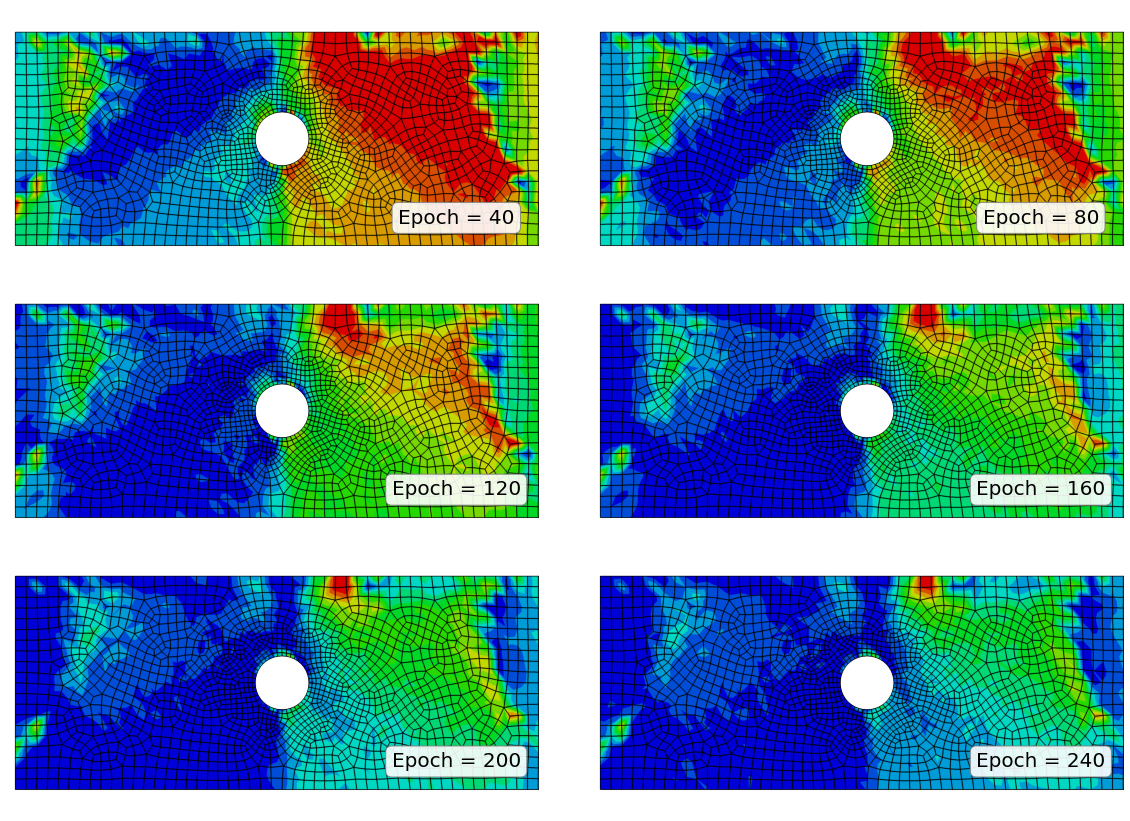

Wall time: 7.97 s


In [195]:
%%time

plot_epoch(key = "img_sample", fileName = 'visualization_sample.pdf')

<Figure size 1008x432 with 0 Axes>

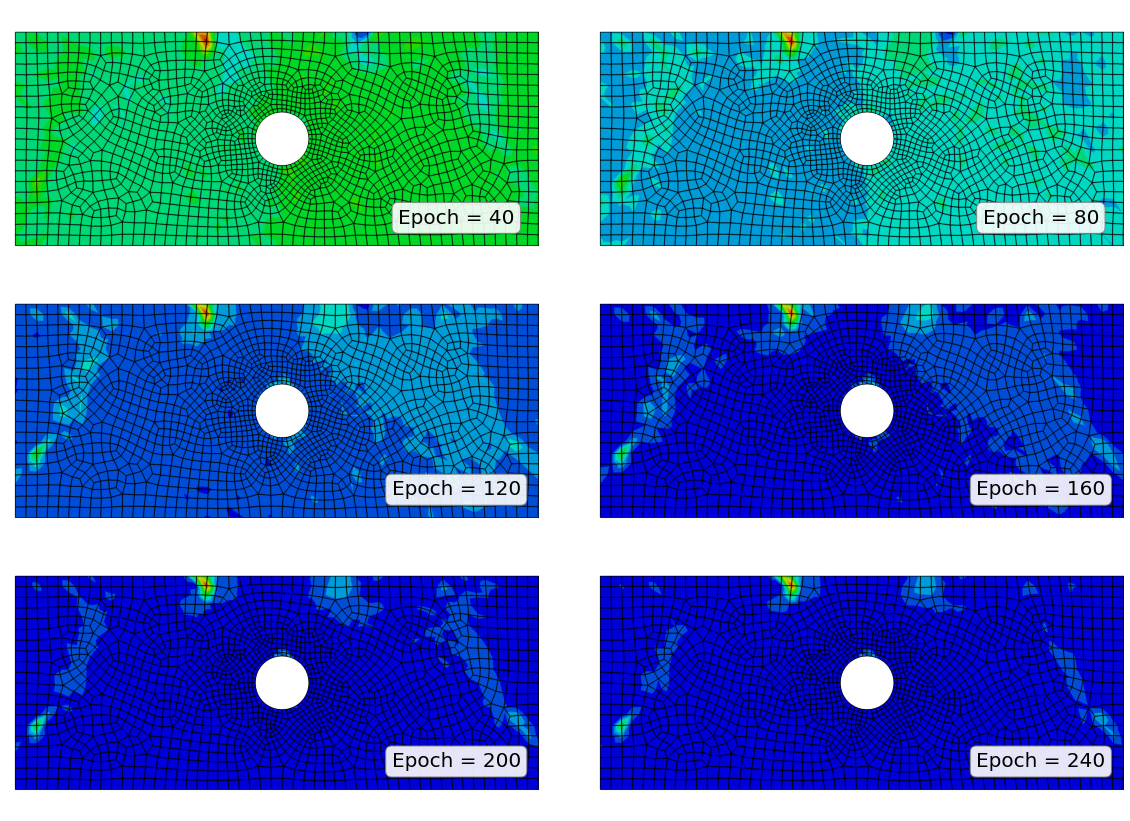

Wall time: 8.13 s


In [196]:
%%time

plot_epoch()

In [178]:
data[40]['X'] # input to the illustrated outlier

array([ 1.5414956 , -0.99273413,  1.4650522 ], dtype=float32)

<Figure size 1008x432 with 0 Axes>

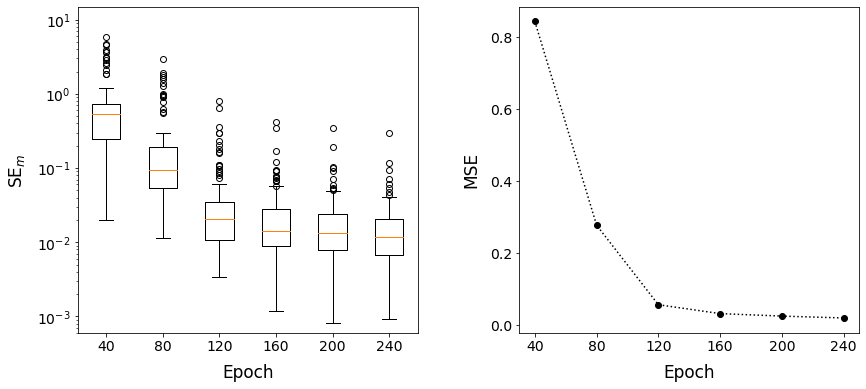

Wall time: 1.06 s


In [92]:
%%time

plt.clf();
epochList = [40,80,120,160,200,240]
plt.rcParams["figure.figsize"] = (14,6)


columns = 2
rows = 1


fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.boxplot(x = boxplot_data, labels=(epochList))
ax1.set_ylabel(r'SE$_{m}$', labelpad=10)
ax1.set_xlabel('Epoch', labelpad=10)
ax1.set_yscale('log')
ax1.set_ylim([0.0006,15])
# plt.tight_layout()

mse = np.mean(np.array(boxplot_data), axis= 1)
ax2.plot(epochList, mse, 'k:o')
ax2.set_ylabel('MSE', labelpad=10)
ax2.set_xlabel('Epoch', labelpad=10)
ax2.set_xticks(epochList)

plt.subplots_adjust(wspace=0.3, hspace=0)
plt.savefig('mse.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [93]:
data = np.loadtxt('time_output_2d.csv', delimiter=",", dtype='float32')

numerical_runtime = np.sum(data)

print('Wall time for numerical datageneration: %s min'%(numerical_runtime//60))

Wall time for numerical datageneration: 55.0 min
